## Preparation

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore")

In [2]:
import STAGATE

In [3]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'D:\\anaconda\envs\STAligner\Lib\R'
os.environ['R_USER'] = 'D:\\anaconda\envs\STAligner\Lib\site-packages\rpy2'

In [4]:
section_ids = ['HCC-5A', 'HCC-5B', 'HCC-5C', 'HCC-5D']

input_path = 'G:/dataset/LICA/input/'
out_dir = 'G:/dataset/LICA/output/STAGATE/'
expriment_name = 'LICA'
# Donor1:7  Donor2:5  Donor3:7
num_cluster = 8

## load data

In [5]:
adata_list = {}
for section_id in section_ids:
    input_dir = os.path.join(input_path, section_id)
    temp_adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
    temp_adata.var_names_make_unique()

    # Truth_df = pd.read_csv(os.path.join(input_dir, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
    # temp_adata.obs['Ground Truth'] = Truth_df.loc[temp_adata.obs_names, 1]

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, 'truth.csv'), sep=',', index_col=0)
    # Ann_df['ground.truth'] = Ann_df['ground.truth'].replace('na', 'unknown')
    temp_adata.obs['Ground Truth'] = Ann_df.loc[temp_adata.obs_names, 'celltype'].astype('category')
    
    
    # make the spot name unique
    temp_adata.obs_names = [x+'_'+section_id for x in temp_adata.obs_names]

    adata_list[section_id] = temp_adata.copy()

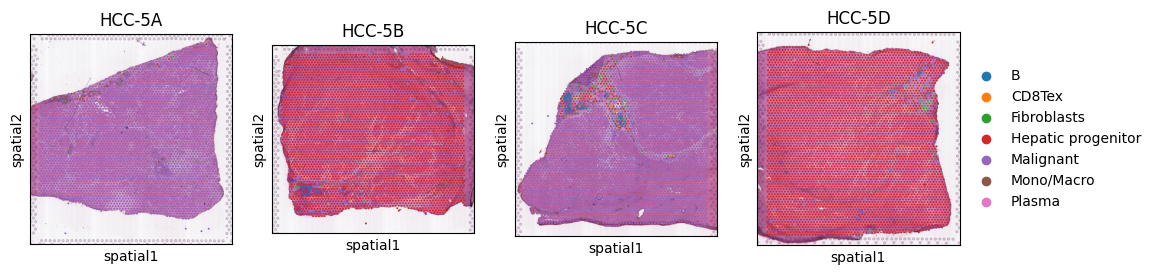

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_ids:
    if it == 3:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["Ground Truth"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["Ground Truth"], title=section_id, show=False)
    it+=1

------Calculating spatial graph...
The graph contains 20212 edges, 3460 cells.
5.8416 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 23212 edges, 3958 cells.
5.8646 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 22120 edges, 3777 cells.
5.8565 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 25532 edges, 4352 cells.
5.8667 neighbors per cell on average.


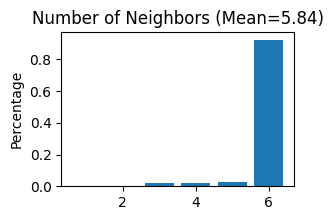

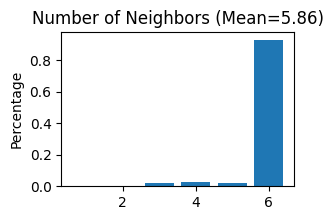

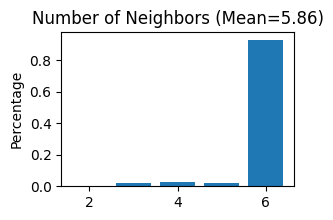

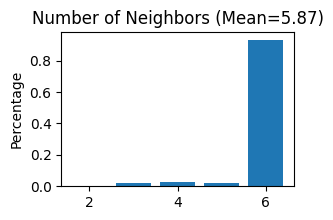

In [7]:
for section_id in section_ids:
    STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=300)
    STAGATE.Stats_Spatial_Net(adata_list[section_id])

## Conbat the scanpy objects and spatial networks

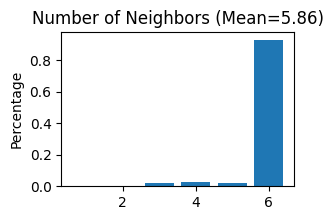

In [8]:
adata = sc.concat([adata_list[x] for x in section_ids], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net'] for x in section_ids])
STAGATE.Stats_Spatial_Net(adata)

## Normalization

In [9]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Running STAGATE

In [10]:
%%time
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (15547, 3000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [12:19<00:00,  1.48s/it]


CPU times: total: 1h 52min 43s
Wall time: 12min 20s


In [11]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

# louvein
# sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=eval_resolution)

adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=num_cluster)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


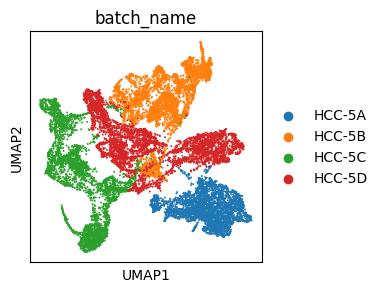

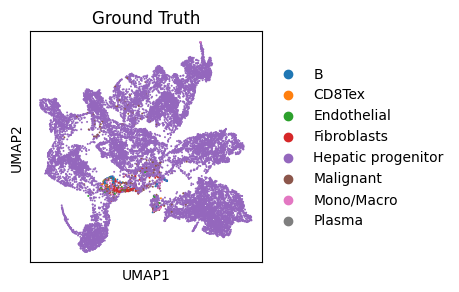

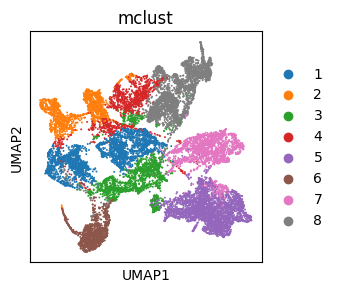

In [12]:
adata.obs['batch_name'] = [x.split('_')[-1] for x in adata.obs_names]

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='batch_name')

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Ground Truth')

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='mclust')

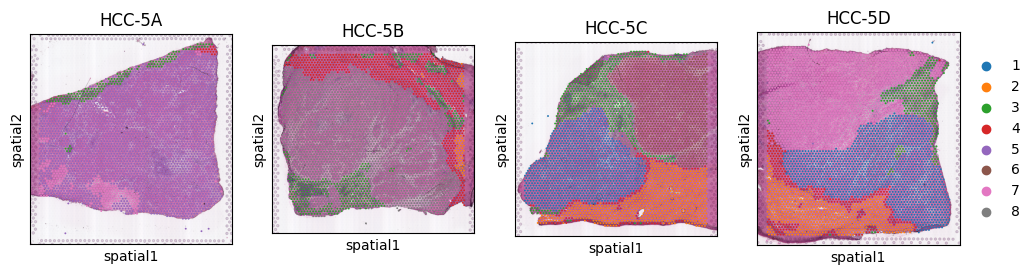

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_ids:
    adata_list[section_id].obs['STAGATE'] = adata.obs.loc[adata_list[section_id].obs_names, 'mclust']
    if it == 3:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["STAGATE"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["STAGATE"], title=section_id, show=False)
    it+=1

##　Calculate ARI

In [14]:
from sklearn.metrics.cluster import adjusted_rand_score

for section_id in section_ids:
    temp_adata = adata[adata.obs['batch_name']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
    print('ARI of section ID %s: %.3f' %(section_id, temp_ARI))

ARI of section ID HCC-5A: 0.209
ARI of section ID HCC-5B: 0.052
ARI of section ID HCC-5C: 0.055
ARI of section ID HCC-5D: 0.029


## Visualization

FileNotFoundError: [Errno 2] No such file or directory: 'G:/dataset/LICA/output/STAGATE/LICA_umap.png'

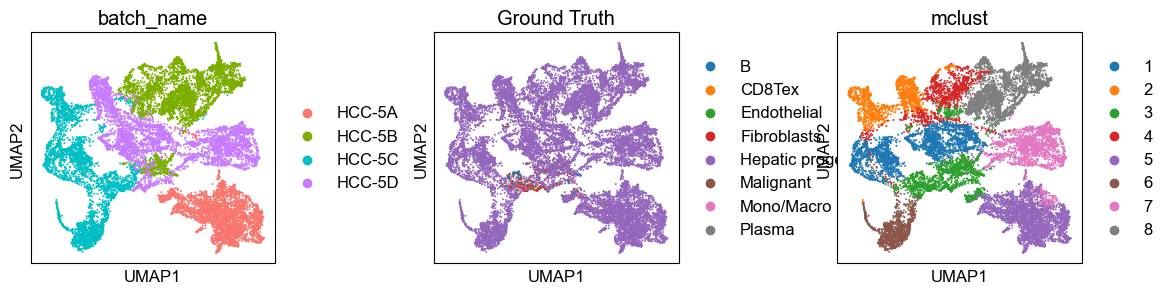

In [15]:
sc.pp.neighbors(adata, use_rep='STAGATE', random_state=666)
sc.tl.umap(adata, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata.uns['batch_name_colors'] = [section_color_dict[x] for x in adata.obs.batch_name.cat.categories]
# adata.obs['mclust'] = pd.Series(ST_utils.match_cluster_labels(adata.obs['Ground Truth'], adata.obs['mclust'].values),
#                                          index=adata.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3,
           wspace=0.5, show=False)
plt.savefig(out_dir + expriment_name + '_umap.png', dpi=300)

In [ ]:
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)

plt.savefig(out_dir + expriment_name + '_ARI.png', dpi=300)
plt.show()

## save

In [ ]:
# save embedding
np.savetxt(out_dir + expriment_name + '_STAGATE.csv', adata.obsm['STAGATE'], delimiter=",")

In [ ]:
print(type(adata))
print(adata.obsm)
print(adata)

print(adata.isbacked)
adata.filename = out_dir + expriment_name + '.h5ad'
print(adata.isbacked)